In [140]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torchvision import datasets,models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from PIL import Image

In [141]:
torch.__version__

'2.1.2'

In [142]:
import torchvision
torchvision.__version__  # should be 0.2.1

'0.16.2'

In [143]:
# Normalize the input images with mean and standard deviation values commonly used for pre-trained models on ImageNet.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [144]:
# Define data transformations for training and validation datasets
data_transforms = {'train':transforms.Compose([transforms.Resize((224,224)),
                                        transforms.RandomAffine(0,shear=10,scale=(0.8,1.2)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        normalize]),
             'validation':transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            normalize])
            }
# Data Loading and Augmentation:

# The RandomAffine transformation is a good choice for data augmentation. You can also consider adding more augmentation techniques like rotation and color jittering.
# Try experimenting with different data augmentation techniques to enhance the model's ability to generalize.

In [145]:
'''
Create datasets
 image_datasets = {
     'train': datasets.ImageFolder(root=train_path, transform=data_transforms['train']),
     'validation': datasets.ImageFolder(root=validation_path, transform=data_transforms['validation'])
 }
 '''
 

"\nCreate datasets\n image_datasets = {\n     'train': datasets.ImageFolder(root=train_path, transform=data_transforms['train']),\n     'validation': datasets.ImageFolder(root=validation_path, transform=data_transforms['validation'])\n }\n "

In [146]:
input_path = '/kaggle/input/alien-vs-predator-images/data/'
train_path = input_path + 'train'
validation_path = input_path + 'validation'

In [147]:
image_dataset = { 'train':  datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])}

In [148]:
image_dataset

{'train': Dataset ImageFolder
     Number of datapoints: 694
     Root location: /kaggle/input/alien-vs-predator-images/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomAffine(degrees=[0.0, 0.0], scale=(0.8, 1.2), shear=[-10.0, 10.0])
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 200
     Root location: /kaggle/input/alien-vs-predator-images/data/validation
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [149]:
import os
#List the contents of the root directory
root_contents=os.listdir('/kaggle/input/alien-vs-predator-images/data/train')
print(root_contents)
#Explore the dataset
for root,dirs,files in os.walk('/kaggle/input/alien-vs-predator-images/data/train'):
    print(f'Root:{root},Directories:{dirs},Files:{files}')

['predator', 'alien']
Root:/kaggle/input/alien-vs-predator-images/data/train,Directories:['predator', 'alien'],Files:[]
Root:/kaggle/input/alien-vs-predator-images/data/train/predator,Directories:[],Files:['208.jpg', '333.jpg', '45.jpg', '56.jpg', '89.jpg', '20.jpg', '275.jpg', '212.jpg', '239.jpg', '58.jpg', '150.jpg', '6.jpg', '109.jpg', '149.jpg', '187.jpg', '76.jpg', '71.jpg', '342.jpg', '272.jpg', '270.jpg', '182.jpg', '215.jpg', '185.jpg', '243.jpg', '153.jpg', '189.jpg', '143.jpg', '327.jpg', '253.jpg', '343.jpg', '115.jpg', '131.jpg', '5.jpg', '151.jpg', '8.jpg', '260.jpg', '202.jpg', '84.jpg', '237.jpg', '273.jpg', '286.jpg', '283.jpg', '85.jpg', '67.jpg', '265.jpg', '289.jpg', '118.jpg', '82.jpg', '295.jpg', '176.jpg', '279.jpg', '30.jpg', '97.jpg', '334.jpg', '106.jpg', '163.jpg', '113.jpg', '160.jpg', '38.jpg', '328.jpg', '211.jpg', '42.jpg', '291.jpg', '197.jpg', '33.jpg', '10.jpg', '234.jpg', '178.jpg', '54.jpg', '271.jpg', '251.jpg', '0.jpg', '130.jpg', '62.jpg', '278.jp

In [150]:
train_dataloader=DataLoader(image_dataset['train'],batch_size=32,shuffle=True,num_workers=0)
validation_dataloader=DataLoader(image_dataset['validation'],batch_size=32,shuffle=False,num_workers=0)

In [151]:
for x,y in validation_dataloader:#Image - color image shape(batch_size,number of channel,length,width)
    print(x.shape)                #Image - Black and white image - number of channels is 1
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [152]:
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [153]:
import torchvision.models as models

# Load ResNet model with pre-trained weights
#resnet = models.resnet50(weights='imagenet')
model = models.resnet50(pretrained=True).to(device) 

for param in model.parameters():
    param.requires_grad = False   #making the pretrained model not to update thats y false
    
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)
).to(device)

In [154]:
from torch.optim import lr_scheduler
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.fc.parameters(),lr=0.001)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)#Consider using a learning rate scheduler to adjust the learning rate during traininng. It can help coneverge faster and achieve better accuracy. 

In [155]:
#steps in the GD: Batch of the input / Pass it to the model / compute loss function / Update the weights
def train(dataloader,model,loss_fn,optimizer):
    model.train()
    for batch,(x,y) in enumerate(dataloader):
    #sending the data to the GOU
        x=x.to(device)
        y=y.to(device)
    #Compute predictions
    pred=model(x)
    #Compute loss
    loss=loss_fn(pred,y)
    #Backpropagation
    loss.backward()#Wnew = wod-lr*dl/dw
    optimizer.step()
    scheduler.step()#ou would then update the learning rate in your training loop
    optimizer.zero_grad()
    
    if batch %100==0:
        print(f'Loss of the model {loss.item()}')

In [156]:
def test(dataloader,model,loss_fn):
    model.eval() #putting the model in the training mode
    '''model.eval()= Sets the model to evaluation mode. 
    This changes the behavior of certain layers like dropout and 
    batch normalization to work differently during training and 
    evaluation.'''
    num_batched = len(dataloader)
    test_loss, correct = 0,0
    with torch.no_grad(): #We will not compute gradients for the test data
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)

      #Compute predictions
            pred = model(X)

      #Compute loss
            test_loss += loss_fn(pred,y).item()

      #Find how many correct predictions  .
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss/num_batched
    correct = correct/(len(dataloader.dataset))

    print(f'Test Accuracy {100*correct}, Avg_loss : {test_loss}')

In [157]:
epochs=5
for t in range(5):
    print(f'Epoch{t+1}')
    train(train_dataloader,model,loss_fn,optimizer)
    test(validation_dataloader,model,loss_fn)

Epoch1
Test Accuracy 82.0, Avg_loss : 0.5991367953164237
Epoch2
Test Accuracy 84.0, Avg_loss : 0.516282034771783
Epoch3
Test Accuracy 89.0, Avg_loss : 0.4522629422800882
Epoch4
Test Accuracy 90.5, Avg_loss : 0.4009053707122803
Epoch5
Test Accuracy 91.0, Avg_loss : 0.35812378994056154


In [163]:
# Ensure that the paths to the validation images are correct
validation_img_paths = ["validation/alien/77.jpg",
                        "validation/alien/46.jpg",
                        "validation/predator/23.jpg"]

In [164]:
# Load images and apply transformations
img_list=[Image.open(input_path + img_path) for img_path in validation_img_paths]
validation_batch=torch.stack([data_transforms['validation'](img).to (device) for img in img_list])

In [165]:
# make predictions
model.eval()
with torch.no_grad():
    pred_logits_tensor=model(validation_batch)
pred_logits_tensor

tensor([[ 0.6262, -1.3451],
        [ 0.0845, -0.3555],
        [-0.2417,  0.4472]], device='cuda:0')

In [166]:
# Calculate probabilities and convert to numpy array
pred_probs=F.softmax(pred_logits_tensor,dim=1).cpu().data.numpy()
pred_probs

array([[0.8777577 , 0.12224219],
       [0.60825264, 0.3917474 ],
       [0.33425975, 0.66574025]], dtype=float32)

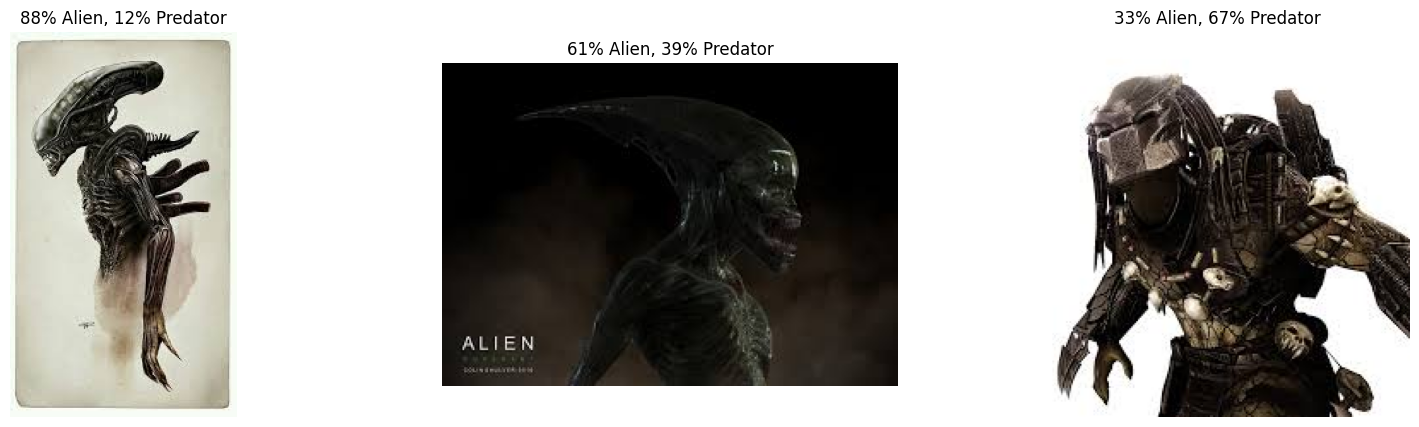

In [167]:
# Visualize results
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

plt.show()